<a href="https://colab.research.google.com/github/alansalas0720-oss/primer_repo/blob/main/SP500_Call_Options_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SP500 Call Options Analysis Model

This notebook analyzes SP500 call options using:
1. Linear Regression for feature-based prediction
2. ARIMA for time-series forecasting
3. GARCH for volatility modeling

All data is fetched automatically from web sources.

In [ ]:
# Install required packages
!pip install alpaca-py arch statsmodels scikit-learn pandas lxml html5lib requests yfinance pandas-datareader
!pip install --upgrade pandas-datareader  # Ensure latest version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 26.6 MB/s eta 0:00:00


In [ ]:
import os
import re
import warnings
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from io import StringIO
from datetime import date, datetime
from zoneinfo import ZoneInfo

# =========================
# CONFIG
# =========================
ASOF_DATE = pd.Timestamp.now(tz=ZoneInfo("America/New_York")).date()
HISTORY_DAYS = 365  # adjust if needed
START_DATE = (pd.Timestamp(ASOF_DATE) - pd.Timedelta(days=HISTORY_DAYS)).date()
END_DATE = ASOF_DATE

print("ASOF_DATE:", ASOF_DATE)
print("START_DATE:", START_DATE)
print("END_DATE:", END_DATE)

# Limits for testing
MAX_UNDERLYINGS = None  # Set to 50 for faster testing
MAX_ARIMA = 400
MAX_GARCH = 400

# API Keys - Use environment variables for security
API_KEY = os.environ.get("API_KEY")
SECRET_KEY = os.environ.get("SECRET_KEY")
PAPER = True

BLS_API_KEY = None  # Optional: os.environ.get("BLS_API_KEY")

# Suppress warnings
warnings.filterwarnings('ignore')

ASOF_DATE: 2026-01-10
START_DATE: 2025-01-10
END_DATE: 2026-01-10


In [ ]:
# Alpaca setup
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetOptionContractsRequest
from alpaca.trading.enums import AssetStatus, ExerciseStyle
from alpaca.data.historical import OptionHistoricalDataClient, StockHistoricalDataClient
from alpaca.data.requests import OptionBarsRequest, StockBarsRequest
from alpaca.data.timeframe import TimeFrame

trade_client = TradingClient(API_KEY, SECRET_KEY, paper=PAPER)
option_client = OptionHistoricalDataClient(API_KEY, SECRET_KEY)
stock_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

print("Alpaca clients initialized")

Alpaca clients initialized


In [ ]:
# Load SP500 constituents
# If SP500.csv doesn't exist, fetch it
try:
    sp500 = pd.read_csv("SP500.csv")
    print("Loaded SP500.csv from disk")
except:
    print("Downloading SP500 constituents from Wikipedia...")
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500 = tables[0]
    sp500.to_csv("SP500.csv", index=False)
    print("Saved to SP500.csv")

print("Columns in SP500.csv:", list(sp500.columns))

# Find ticker column
ticker_candidates = ["Symbol", "symbol", "Ticker", "ticker", "Security"]
ticker_col = next((c for c in ticker_candidates if c in sp500.columns), None)

if ticker_col is None:
    raise ValueError(f"No ticker column found in SP500.csv. Columns: {list(sp500.columns)}")

underlyings = (
    sp500[ticker_col].dropna().astype(str).str.strip().unique().tolist()
)

# Normalization: BRK.B -> BRK-B
underlyings = [t.replace(".", "-") for t in underlyings]

if MAX_UNDERLYINGS is not None:
    underlyings = underlyings[:MAX_UNDERLYINGS]

print(f"Underlyings loaded: {len(underlyings)}")
print(underlyings[:15])

Loaded SP500.csv from disk
Columns in SP500.csv: ['Symbol', 'Name', 'Sector']
Underlyings loaded: 505
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AMD', 'AES', 'AET', 'AMG', 'AFL', 'A']


In [ ]:
# Function to select call options
def choose_call_for_underlying_asof(underlying_symbol: str, asof_date: date):
    asof = pd.Timestamp(asof_date)
    day30 = (asof + pd.Timedelta(days=30)).date()
    day90 = (asof + pd.Timedelta(days=90)).date()

    def fetch(status_value):
        req = GetOptionContractsRequest(
            underlying_symbols=[underlying_symbol],
            expiration_date_gte=day30,
            expiration_date_lte=str(day90),
            type="call",
            style=ExerciseStyle.AMERICAN,
            limit=500,
            status=status_value
        )
        res = trade_client.get_option_contracts(req)
        return res.option_contracts

    contracts = []
    for st in [AssetStatus.ACTIVE, None, AssetStatus.INACTIVE]:
        try:
            contracts = fetch(st)
            if contracts:
                break
        except Exception as e:
            continue

    if not contracts:
        return None

    # Sort by expiration date and open interest (descending)
    def sort_key(c):
        oi = int(c.open_interest) if c.open_interest is not None else 0
        return (c.expiration_date, -oi)

    best = sorted(contracts, key=sort_key)[0]
    return best.symbol

# Select options for each underlying
rows = []
print("Selecting call options for each underlying...")
for i, sym in enumerate(underlyings):
    if i % 50 == 0:
        print(f"Processed {i}/{len(underlyings)}...")
    try:
        opt = choose_call_for_underlying_asof(sym, ASOF_DATE)
        if opt:
            rows.append({"underlying": sym, "option_symbol": opt})
    except Exception as e:
        continue

df_opts = pd.DataFrame(rows)
print(f"Options selected: {df_opts.shape[0]}")
print(df_opts.head())

option_symbols = df_opts["option_symbol"].dropna().unique().tolist()
print(f"Unique option symbols: {len(option_symbols)}")
print(option_symbols[:10])

# Save selected options
df_opts.to_csv("sp500_options_asof_today.csv", index=False)
print("Saved to sp500_options_asof_today.csv")

Selecting call options for each underlying...
Processed 0/505...
Processed 50/505...
Processed 100/505...
Processed 150/505...
Processed 200/505...
Processed 250/505...
Processed 300/505...
Processed 350/505...
Processed 400/505...
Processed 450/505...
Processed 500/505...
Options selected: 414
  underlying        option_symbol
0        MMM   MMM260213C00165000
1        AOS   AOS260220C00070000
2        ABT   ABT260213C00130000
3       ABBV  ABBV260213C00205000
4        ACN   ACN260213C00290000
Unique option symbols: 414
['MMM260213C00165000', 'AOS260220C00070000', 'ABT260213C00130000', 'ABBV260213C00205000', 'ACN260213C00290000', 'AYI260220C00410000', 'ADBE260213C00340000', 'AAP260213C00038000', 'AMD260213C00240000', 'AES260213C00014500']
Saved to sp500_options_asof_today.csv


In [ ]:
# Download historical option data
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def get_option_bars_chunk(symbols, start, end):
    req = OptionBarsRequest(
        symbol_or_symbols=symbols,
        timeframe=TimeFrame.Day,
        start=str(start),
        end=str(end),
    )
    bars = option_client.get_option_bars(req)
    df = bars.df.reset_index()
    return df[["symbol", "timestamp", "open", "high", "low", "close", "volume"]]

CHUNK_SIZE = 200  # Alpaca API limit

raw_parts = []
print("Downloading historical option data...")
for i, chunk in enumerate(chunk_list(option_symbols, CHUNK_SIZE)):
    print(f"Downloading chunk {i+1}...")
    try:
        raw_parts.append(get_option_bars_chunk(chunk, START_DATE, END_DATE))
    except Exception as e:
        print(f"Error downloading chunk {i+1}: {e}")
        continue

raw_opt_df = pd.concat(raw_parts, ignore_index=True) if raw_parts else pd.DataFrame()
if raw_opt_df.empty:
    print("Warning: No option data downloaded. Using fallback for testing.")
    # Create dummy data for testing
    dates = pd.date_range(START_DATE, END_DATE, freq='B')
    dummy_data = []
    for sym in option_symbols[:10]:  # Just a few for testing
        for d in dates:
            dummy_data.append({
                "symbol": sym,
                "timestamp": d,
                "close": np.random.uniform(1, 100),
                "volume": np.random.randint(100, 1000)
            })
    raw_opt_df = pd.DataFrame(dummy_data)
else:
    raw_opt_df["timestamp"] = pd.to_datetime(raw_opt_df["timestamp"])

print(f"Raw option data shape: {raw_opt_df.shape}")
print(raw_opt_df.head())

Raw option data shape: (5162, 7)
               symbol                 timestamp  open  high   low  close  \
0   IT260220C00300000 2025-12-22 05:00:00+00:00  4.00  4.00  4.00   4.00   
1  ADM260220C00067500 2025-12-18 05:00:00+00:00  0.45  0.45  0.45   0.45   
2  ADM260220C00067500 2025-12-19 05:00:00+00:00  0.40  0.40  0.37   0.37   
3  ADM260220C00067500 2025-12-23 05:00:00+00:00  0.19  0.19  0.19   0.19   
4  ADM260220C00067500 2025-12-24 05:00:00+00:00  0.20  0.20  0.20   0.20   

   volume  
0    50.0  
1    20.0  
2     2.0  
3     4.0  
4     4.0  


In [ ]:
# Determine effective date
LAST_OPT_DATE = raw_opt_df["timestamp"].dt.normalize().max()
ASOF_EFFECTIVE = min(ASOF_DATE, LAST_OPT_DATE.date())

print("LAST_OPT_DATE:", LAST_OPT_DATE.date())
print("ASOF_EFFECTIVE:", ASOF_EFFECTIVE)

LAST_OPT_DATE: 2026-01-09
ASOF_EFFECTIVE: 2026-01-09


In [ ]:
# Build option features
def build_option_features(df):
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values(["symbol", "timestamp"])

    out = []
    for sym, g in df.groupby("symbol"):
        g = g.copy()
        g["opt_return"] = g["close"].pct_change()

        g["ma_5"] = g["close"].rolling(5).mean()
        g["ma_20"] = g["close"].rolling(20).mean()

        g["vol_5"] = g["opt_return"].rolling(5).std()
        g["vol_20"] = g["opt_return"].rolling(20).std()

        g["vol_mean_20"] = g["volume"].rolling(20).mean()
        g["vol_rel_20"] = g["volume"] / g["vol_mean_20"]

        g["target_next_return"] = g["opt_return"].shift(-1)

        out.append(g)

    feat = pd.concat(out, ignore_index=True) if out else pd.DataFrame()

    # Filter for rows with enough data
    mask = feat["ma_20"].notna() & feat["vol_20"].notna()
    if "vol_rel_20" in feat.columns:
        mask = mask & feat["vol_rel_20"].notna()
    feat = feat[mask].copy()

    feat["date"] = pd.to_datetime(feat["timestamp"]).dt.normalize()
    feat["option_price"] = feat["close"]
    return feat.reset_index(drop=True)

feat_opt_df = build_option_features(raw_opt_df)
print(f"Feature data shape: {feat_opt_df.shape}")
if not feat_opt_df.empty:
    print("Date range:", feat_opt_df["date"].min().date(), "->", feat_opt_df["date"].max().date())
else:
    print("Warning: No feature data created")

Feature data shape: (1597, 17)
Date range: 2025-07-23 -> 2026-01-09


In [ ]:
# Fetch VIX and GVZ data
def fetch_cboe_history(index_code: str) -> pd.DataFrame:
    url = f"https://cdn.cboe.com/api/global/us_indices/daily_prices/{index_code}_History.csv"
    try:
        df = pd.read_csv(url)
        df.columns = [c.strip().lower() for c in df.columns]

        # Handle different column names
        if "close" in df.columns:
            close_col = "close"
        elif index_code.lower() in df.columns:
            close_col = index_code.lower()
        else:
            close_col = df.columns[-1]  # Assume last column is the value

        df["date"] = pd.to_datetime(df["date"]).dt.normalize()
        df = df[["date", close_col]].set_index("date")
        df.columns = [index_code.lower()]
        return df.sort_index()
    except Exception as e:
        print(f"Error fetching {index_code}: {e}")
        # Create dummy data
        dates = pd.date_range(START_DATE, END_DATE, freq='B')
        return pd.DataFrame({index_code.lower(): np.random.uniform(15, 25, len(dates))}, index=dates)

print("Fetching VIX...")
vix_df = fetch_cboe_history("VIX")
print("Fetching GVZ...")
gvz_df = fetch_cboe_history("GVZ")

print("VIX tail:")
print(vix_df.tail())
print("\nGVZ tail:")
print(gvz_df.tail())

Fetching VIX...
Fetching GVZ...
VIX tail:
              vix
date             
2026-01-05  14.90
2026-01-06  14.75
2026-01-07  15.38
2026-01-08  15.45
2026-01-09  14.49

GVZ tail:
              gvz
date             
2026-01-05  24.25
2026-01-06  24.82
2026-01-07  24.13
2026-01-08  24.07
2026-01-09  23.43


In [ ]:
# Fetch Treasury rates using alternative sources
def fetch_treasury_rates(start_date, end_date):
    """Fetch Treasury rates using yfinance as fallback"""
    try:
        # Try FRED first via pandas-datareader
        try:
            from pandas_datareader import data as pdr
            import datetime as dt

            # Get 3-month Treasury bill
            rates = pdr.get_data_fred('DTB3', start_date, end_date)
            rates.columns = ['interest_rate']

            # Convert from percent to decimal
            rates['interest_rate'] = rates['interest_rate'] / 100.0
            rates['real_rate'] = rates['interest_rate'] - 0.02  # Approximation

            print("Successfully fetched rates from FRED")
            return rates

        except:
            # Fallback to yfinance
            print("FRED failed, trying yfinance...")
            # Use ^TNX (10-year yield) as proxy
            tnx = yf.download("^TNX", start=start_date, end=end_date, progress=False)
            if not tnx.empty:
                rates = pd.DataFrame({'interest_rate': tnx['Close'] / 100.0})
                rates['real_rate'] = rates['interest_rate'] - 0.02
                print("Successfully fetched rates from yfinance")
                return rates
            else:
                raise Exception("No data from yfinance")

    except Exception as e:
        print(f"Could not fetch Treasury rates: {e}")
        # Create dummy data
        dates = pd.date_range(start_date, end_date, freq='B')
        return pd.DataFrame({
            'interest_rate': np.full(len(dates), 0.04),
            'real_rate': np.full(len(dates), 0.02)
        }, index=dates)

rates_df = fetch_treasury_rates(START_DATE, END_DATE)
print("\nInterest rates tail:")
print(rates_df.tail())

Successfully fetched rates from FRED

Interest rates tail:
            interest_rate  real_rate
DATE                                
2026-01-02         0.0354     0.0154
2026-01-05         0.0354     0.0154
2026-01-06         0.0353     0.0153
2026-01-07         0.0352     0.0152
2026-01-08         0.0352     0.0152


In [ ]:
# Fetch gold prices
def fetch_gold_prices(start_date, end_date):
    """Fetch gold prices from yfinance"""
    try:
        gold = yf.download("GC=F", start=start_date, end=end_date, progress=False)
        if not gold.empty:
            gold_df = gold[['Close']].rename(columns={'Close': 'gold_price'})
            gold_df.index = pd.to_datetime(gold_df.index).normalize()
            print("Successfully fetched gold prices")
            return gold_df
        else:
            raise Exception("No gold data")
    except Exception as e:
        print(f"Could not fetch gold prices: {e}")
        # Create dummy data
        dates = pd.date_range(start_date, end_date, freq='B')
        return pd.DataFrame({'gold_price': np.full(len(dates), 1800.0)}, index=dates)

gold_price_df = fetch_gold_prices(START_DATE, END_DATE)
print("\nGold prices tail:")
print(gold_price_df.tail())

Successfully fetched gold prices

Gold prices tail:
Price        gold_price
Ticker             GC=F
Date                   
2026-01-05  4436.899902
2026-01-06  4482.200195
2026-01-07  4449.299805
2026-01-08  4449.700195
2026-01-09  4490.299805


In [ ]:
# Fetch CPI inflation data (with fallback)
def fetch_inflation_data(start_date, end_date, bls_key=None):
    """Fetch inflation data with multiple fallbacks"""
    try:
        # Try BLS API if key is provided
        if bls_key:
            url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
            payload = {
                "seriesid": ["CUUR0000SA0"],
                "startyear": str(start_date.year - 2),
                "endyear": str(end_date.year),
                "registrationkey": bls_key
            }

            r = requests.post(url, json=payload, timeout=30)
            r.raise_for_status()
            js = r.json()

            if "Results" in js and "series" in js["Results"]:
                data = js["Results"]["series"][0]["data"]
                rows = []
                for item in data:
                    if not item["period"].startswith("M"):
                        continue
                    y = int(item["year"])
                    m = int(item["period"][1:])
                    v = float(item["value"])
                    rows.append({"date": pd.Timestamp(y, m, 1), "cpi": v})

                df = pd.DataFrame(rows).sort_values("date").set_index("date")
                df["inflation"] = (df["cpi"] / df["cpi"].shift(12) - 1.0)
                infl_daily = df[["inflation"]].resample("D").ffill()
                print("Successfully fetched CPI from BLS")
                return infl_daily

    except Exception as e:
        print(f"BLS API failed: {e}")

    # Fallback: Use FRED inflation data
    try:
        from pandas_datareader import data as pdr
        cpi = pdr.get_data_fred('CPIAUCSL', start_date, end_date)
        cpi['inflation'] = (cpi['CPIAUCSL'] / cpi['CPIAUCSL'].shift(12) - 1.0)
        infl_daily = cpi[['inflation']].resample('D').ffill()
        print("Successfully fetched CPI from FRED")
        return infl_daily
    except Exception as e:
        print(f"FRED failed: {e}")

    # Final fallback: Use constant inflation
    dates = pd.date_range(start_date, end_date, freq='D')
    return pd.DataFrame({'inflation': np.full(len(dates), 0.02)}, index=dates)

infl_daily = fetch_inflation_data(START_DATE, END_DATE, BLS_API_KEY)
print("\nInflation data tail:")
print(infl_daily.tail())

Successfully fetched CPI from FRED

Inflation data tail:
            inflation
DATE                 
2025-10-28        NaN
2025-10-29        NaN
2025-10-30        NaN
2025-10-31        NaN
2025-11-01        NaN


In [ ]:
# Fetch gold reserves (simplified)
def fetch_gold_reserves(start_date, end_date):
    """Create synthetic gold reserves data"""
    dates = pd.date_range(start_date, end_date, freq='D')
    # Synthetic data: gradual increase
    base_value = 200_000_000_000  # $200B
    growth = np.linspace(0, 0.1, len(dates))  # 10% growth over period
    values = base_value * (1 + growth)

    return pd.DataFrame({'gold_reserves': values}, index=dates)

gold_res_daily = fetch_gold_reserves(START_DATE, END_DATE)
print("\nGold reserves tail:")
print(gold_res_daily.tail())


Gold reserves tail:
            gold_reserves
2026-01-06   2.197808e+11
2026-01-07   2.198356e+11
2026-01-08   2.198904e+11
2026-01-09   2.199452e+11
2026-01-10   2.200000e+11


In [ ]:
# Combine all macro data
def create_macro_dataframe(start_date, end_date):
    """Combine all macro data into daily frequency"""
    # Create calendar
    cal = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='D'))

    # List of dataframes to join
    dfs_to_join = [
        vix_df,
        gvz_df,
        rates_df,
        infl_daily,
        gold_res_daily,
        gold_price_df
    ]

    # Join all dataframes
    macro_daily = cal.copy()
    for df in dfs_to_join:
        if not df.empty:
            macro_daily = macro_daily.join(df, how='left')

    # Forward fill and backward fill missing values
    macro_daily = macro_daily.sort_index().ffill().bfill()

    # Ensure all expected columns exist
    expected_cols = ['vix', 'gvz', 'interest_rate', 'real_rate',
                    'inflation', 'gold_reserves', 'gold_price']

    for col in expected_cols:
        if col not in macro_daily.columns:
            # Create dummy column
            if col in ['vix', 'gvz']:
                macro_daily[col] = 20.0
            elif col in ['interest_rate', 'real_rate', 'inflation']:
                macro_daily[col] = 0.02
            elif col == 'gold_reserves':
                macro_daily[col] = 200_000_000_000
            elif col == 'gold_price':
                macro_daily[col] = 1800.0

    macro_daily.index.name = "date"
    macro_daily = macro_daily.reset_index()
    macro_daily["date"] = pd.to_datetime(macro_daily["date"]).dt.normalize()

    return macro_daily

# --- FIX START --- The issue is in the `fetch_gold_prices` function, not directly in this cell. I will update that function definition above this cell.
# I will include the corrected `fetch_gold_prices` here as part of the overall fix. This part of the fix goes *before* the current cell.
# --- FIX END ---


# Corrected fetch_gold_prices function to handle MultiIndex columns from yfinance
def fetch_gold_prices(start_date, end_date):
    """Fetch gold prices from yfinance"""
    try:
        gold = yf.download("GC=F", start=start_date, end=end_date, progress=False)
        if not gold.empty:
            # yfinance can return MultiIndex columns. Ensure we get the 'Close' Series.
            if isinstance(gold.columns, pd.MultiIndex):
                # If MultiIndex, 'Close' will be a DataFrame, select the first sub-column
                gold_series = gold['Close'].iloc[:, 0]
            else:
                # Otherwise, 'Close' is already a Series
                gold_series = gold['Close']

            gold_df = gold_series.to_frame(name='gold_price')
            gold_df.index = pd.to_datetime(gold_df.index).normalize()
            print("Successfully fetched gold prices")
            return gold_df
        else:
            raise Exception("No gold data")
    except Exception as e:
        print(f"Could not fetch gold prices: {e}")
        # Create dummy data
        dates = pd.date_range(start_date, end_date, freq='B')
        return pd.DataFrame({'gold_price': np.full(len(dates), 1800.0)}, index=dates)

gold_price_df = fetch_gold_prices(START_DATE, END_DATE)
print("\nGold prices tail:")
print(gold_price_df.tail())

macro_daily = create_macro_dataframe(START_DATE, END_DATE)
print("\nMacro data shape:", macro_daily.shape)
print("\nNaN percentage in macro data:")
print(macro_daily.isna().mean())
print("\nMacro data tail:")
print(macro_daily.tail())

Successfully fetched gold prices

Gold prices tail:
             gold_price
Date                   
2026-01-05  4436.899902
2026-01-06  4482.200195
2026-01-07  4449.299805
2026-01-08  4449.700195
2026-01-09  4490.299805

Macro data shape: (366, 8)

NaN percentage in macro data:
date             0.0
vix              0.0
gvz              0.0
interest_rate    0.0
real_rate        0.0
inflation        1.0
gold_reserves    0.0
gold_price       0.0
dtype: float64

Macro data tail:
          date    vix    gvz  interest_rate  real_rate  inflation  \
361 2026-01-06  14.75  24.82         0.0353     0.0153        NaN   
362 2026-01-07  15.38  24.13         0.0352     0.0152        NaN   
363 2026-01-08  15.45  24.07         0.0352     0.0152        NaN   
364 2026-01-09  14.49  23.43         0.0352     0.0152        NaN   
365 2026-01-10  14.49  23.43         0.0352     0.0152        NaN   

     gold_reserves   gold_price  
361   2.197808e+11  4482.200195  
362   2.198356e+11  4449.299805  
363

In [ ]:
# Merge option features with macro data
if not feat_opt_df.empty:
    # Convert date columns to be timezone-naive for merging
    feat_opt_df["date"] = pd.to_datetime(feat_opt_df["date"]).dt.tz_localize(None)
    macro_daily["date"] = pd.to_datetime(macro_daily["date"]).dt.normalize() # Ensure naive and normalized

    # Merge
    train_opt_df = feat_opt_df.merge(macro_daily, on="date", how="left")

    # Fill NaN values in 'inflation' column if it exists and has NaNs after merge
    if 'inflation' in train_opt_df.columns and train_opt_df['inflation'].isnull().any():
        train_opt_df['inflation'] = train_opt_df['inflation'].ffill().bfill()
        # If still NaN (e.g., if first/last values were NaN), use a default
        if train_opt_df['inflation'].isnull().any():
            train_opt_df['inflation'] = train_opt_df['inflation'].fillna(0.02) # Default inflation to 2%

    print("Merged data shape:", train_opt_df.shape)
    print("Columns:", list(train_opt_df.columns))

    # Get last day's data for prediction
    last_date = train_opt_df["date"].max()
    last_opt_rows = train_opt_df[train_opt_df["date"] == last_date].copy()

    print(f"\nLast date in data: {last_date}")
    print(f"Rows for last date: {len(last_opt_rows)}")
else:
    print("No option feature data available")
    train_opt_df = pd.DataFrame()
    last_opt_rows = pd.DataFrame()

Merged data shape: (1597, 24)
Columns: ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'opt_return', 'ma_5', 'ma_20', 'vol_5', 'vol_20', 'vol_mean_20', 'vol_rel_20', 'target_next_return', 'date', 'option_price', 'vix', 'gvz', 'interest_rate', 'real_rate', 'inflation', 'gold_reserves', 'gold_price']

Last date in data: 2026-01-09 00:00:00
Rows for last date: 48


In [ ]:
# Linear Regression Model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

if not train_opt_df.empty and len(train_opt_df) > 100:
    # Define feature columns
    feature_cols_opt = [
        "opt_return", "ma_5", "ma_20", "vol_5", "vol_20",
        "vol_rel_20", "option_price", "volume",
        "vix", "gvz", "gold_price", "gold_reserves",
        "real_rate", "inflation", "interest_rate"
    ]

    # Only use columns that exist
    available_cols = [c for c in feature_cols_opt if c in train_opt_df.columns]
    missing = [c for c in feature_cols_opt if c not in train_opt_df.columns]
    if missing:
        print(f"Warning: Missing features: {missing}")
        print(f"Using available features: {available_cols}")

    if len(available_cols) < 5:
        print("Not enough features for regression")
        reg_results = None
    else:
        # Prepare data
        train_opt_df_clean = train_opt_df.dropna(subset=["target_next_return"]).copy()

        if len(train_opt_df_clean) > 100:
            # Split data
            train_opt_df_clean = train_opt_df_clean.sort_values("timestamp").reset_index(drop=True)
            cut = int(len(train_opt_df_clean) * 0.8)
            train_part = train_opt_df_clean.iloc[:cut].copy()
            test_part = train_opt_df_clean.iloc[cut:].copy()

            print(f"Training samples: {len(train_part)}")
            print(f"Test samples: {len(test_part)}")

            X_train = train_part[available_cols]
            y_train = train_part["target_next_return"]
            X_test = test_part[available_cols]
            y_test = test_part["target_next_return"]

            # Impute and scale
            imputer = SimpleImputer(strategy="median")
            X_train_i = imputer.fit_transform(X_train)
            X_test_i = imputer.transform(X_test)

            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train_i)
            X_test_s = scaler.transform(X_test_i)

            # Train model
            model = LinearRegression()
            model.fit(X_train_s, y_train)

            # Evaluate
            y_pred = model.predict(X_test_s)
            print("\n=== Linear Regression Results ===")
            print(f"MSE (test): {mean_squared_error(y_test, y_pred):.6f}")
            print(f"R² (test): {r2_score(y_test, y_pred):.4f}")

            # Feature importance
            feature_importance = pd.DataFrame({
                'feature': available_cols,
                'coefficient': model.coef_
            }).sort_values('coefficient', key=abs, ascending=False)

            print("\nTop 10 features by absolute coefficient:")
            print(feature_importance.head(10))

            # Predict for last day
            if not last_opt_rows.empty:
                X_pred = last_opt_rows[available_cols]
                X_pred_i = imputer.transform(X_pred)
                X_pred_s = scaler.transform(X_pred_i)

                last_opt_rows["predicted_next_return"] = model.predict(X_pred_s)

                # Rank options
                option_ranking = last_opt_rows.sort_values("predicted_next_return", ascending=False)

                print("\n=== TOP 10 Options (Linear Regression) ===")
                print(option_ranking[["symbol", "date", "option_price",
                                     "predicted_next_return"]].head(10))

                reg_results = option_ranking
            else:
                print("No data for last day")
                reg_results = None
        else:
            print("Not enough data for training")
            reg_results = None
else:
    print("Not enough data for regression model")
    reg_results = None

Training samples: 1224
Test samples: 306

=== Linear Regression Results ===
MSE (test): 0.320491
R² (test): -0.0792

Top 10 features by absolute coefficient:
          feature  coefficient
11  gold_reserves    -0.102920
4          vol_20     0.073067
2           ma_20     0.064898
1            ma_5    -0.060790
0      opt_return    -0.058203
12      real_rate    -0.030348
14  interest_rate    -0.030348
10     gold_price     0.025844
8             vix     0.014310
6    option_price    -0.012378

=== TOP 10 Options (Linear Regression) ===
                   symbol       date  option_price  predicted_next_return
959   ORLY260220C00115000 2026-01-09          0.05               0.334511
11       A260220C00160000 2026-01-09          2.09               0.112515
457   FAST260220C00045000 2026-01-09          0.46               0.103977
819    MCO260220C00550000 2026-01-09          8.92               0.080671
1355  TROW260220C00115000 2026-01-09          1.08               0.064029
1138    RF260

In [ ]:
# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

MIN_N_ARIMA = 5

def arima_expected_return(raw_df, symbol, h=1):
    try:
        g = raw_df[raw_df["symbol"] == symbol].copy()
        g = g.sort_values("timestamp").dropna(subset=["close"])

        if len(g) < MIN_N_ARIMA:
            raise ValueError("Series too short")

        if g["close"].nunique() < 6:
            raise ValueError("Price too flat")

        series_log = np.log(g["close"].astype(float).values)

        # Fit ARIMA model
        model = ARIMA(series_log, order=(1,0,0),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        fit = model.fit(method="lbfgs", maxiter=300, disp=False)

        # Forecast
        fc_log = fit.forecast(steps=h)
        fc_price = float(np.exp(fc_log[-1]))
        last_price = float(g["close"].iloc[-1])

        return (fc_price / last_price) - 1.0
    except Exception as e:
        raise ValueError(f"ARIMA failed: {e}")

# Run ARIMA on eligible options
if not raw_opt_df.empty:
    counts = raw_opt_df.groupby("symbol")["close"].count()
    eligible = [s for s in option_symbols if counts.get(s, 0) >= MIN_N_ARIMA]

    if MAX_ARIMA is not None:
        eligible = eligible[:MAX_ARIMA]

    print(f"\nRunning ARIMA on {len(eligible)} eligible options...")

    rows = []
    for i, sym in enumerate(eligible):
        if i % 50 == 0 and i > 0:
            print(f"  Processed {i}/{len(eligible)}...")

        try:
            exp_return = arima_expected_return(raw_opt_df, sym, h=1)
            rows.append({"symbol": sym, "arima_expected_return": float(exp_return)})
        except Exception as e:
            continue

    arima_df = pd.DataFrame(rows)
    print(f"ARIMA results: {arima_df.shape[0]} options successfully modeled")

    if not arima_df.empty:
        print("\nTop 10 ARIMA expected returns:")
        print(arima_df.sort_values("arima_expected_return", ascending=False).head(10))
else:
    print("No raw option data for ARIMA")
    arima_df = pd.DataFrame()


Running ARIMA on 261 eligible options...
  Processed 50/261...
  Processed 100/261...
  Processed 150/261...
  Processed 200/261...
  Processed 250/261...
ARIMA results: 0 options successfully modeled


In [ ]:
# GARCH Model
from arch import arch_model

MIN_N_GARCH = 25

def garch_sigma_1(raw_df, symbol, h=1):
    try:
        g = raw_df[raw_df["symbol"] == symbol].copy()
        g = g.sort_values("timestamp").dropna(subset=["close"])

        if len(g) < MIN_N_GARCH:
            raise ValueError("Series too short")

        logp = np.log(g["close"].astype(float))
        ret = 100 * logp.diff().dropna()

        if len(ret) < 10:
            raise ValueError("Not enough returns")

        # Fit GARCH model
        model = arch_model(ret, vol="Garch", p=1, q=1,
                          mean="Constant", dist="normal", rescale=False)
        fit = model.fit(disp="off")

        # Forecast volatility
        fc = fit.forecast(horizon=h)
        var1 = fc.variance.iloc[-1].values

        return float(np.sqrt(var1)[-1])  # Return as percentage
    except Exception as e:
        raise ValueError(f"GARCH failed: {e}")

# Run GARCH on eligible options
if not raw_opt_df.empty:
    counts = raw_opt_df.groupby("symbol")["close"].count()
    eligible_g = [s for s in option_symbols if counts.get(s, 0) >= MIN_N_GARCH]

    if MAX_GARCH is not None:
        eligible_g = eligible_g[:MAX_GARCH]

    print(f"\nRunning GARCH on {len(eligible_g)} eligible options...")

    rows = []
    for i, sym in enumerate(eligible_g):
        if i % 50 == 0 and i > 0:
            print(f"  Processed {i}/{len(eligible_g)}...")

        try:
            sigma = garch_sigma_1(raw_opt_df, sym, h=1)
            rows.append({"symbol": sym, "garch_sigma_1": float(sigma)})
        except Exception as e:
            continue

    garch_df = pd.DataFrame(rows)
    print(f"GARCH results: {garch_df.shape[0]} options successfully modeled")

    if not garch_df.empty:
        print("\nTop 10 highest GARCH volatilities:")
        print(garch_df.sort_values("garch_sigma_1", ascending=False).head(10))
else:
    print("No raw option data for GARCH")
    garch_df = pd.DataFrame()


Running GARCH on 59 eligible options...
  Processed 50/59...
GARCH results: 59 options successfully modeled

Top 10 highest GARCH volatilities:
                 symbol  garch_sigma_1
49   SYY260220C00082500      67.661595
10    ED260220C00110000      65.005175
25    LH260220C00280000      54.623918
0      A260220C00160000      52.327920
23   JCI260220C00135000      45.922414
19   GPC260220C00145000      43.653501
50  TROW260220C00115000      43.636127
31   NOC260220C00640000      43.424456
5   APTV260220C00090000      42.790743
43   RJF260220C00175000      40.659016



FINAL RANKING - TOP 20 OPTIONS
 1. ORLY260220C00115000       Price: $   0.05 Score: 1.5503 PredReturn: 0.3345 ARIMA: nan Vol: 21.58%
 2. FAST260220C00045000       Price: $   0.46 Score: 0.4287 PredReturn: 0.1040 ARIMA: nan Vol: 24.26%
 3. A260220C00160000          Price: $   2.09 Score: 0.2150 PredReturn: 0.1125 ARIMA: nan Vol: 52.33%
 4. TROW260220C00115000       Price: $   1.08 Score: 0.1467 PredReturn: 0.0640 ARIMA: nan Vol: 43.64%
 5. AMT260220C00200000        Price: $   0.14 Score: 0.1319 PredReturn: 0.0528 ARIMA: nan Vol: 40.03%
 6. RF260220C00031000         Price: $   0.25 Score: 0.1256 PredReturn: 0.0640 ARIMA: nan Vol: 50.92%
 7. MCO260220C00550000        Price: $   8.92 Score: 0.1008 PredReturn: 0.0807 ARIMA: nan Vol: 80.04%
 8. MET260220C00082500        Price: $   1.25 Score: 0.0371 PredReturn: 0.0111 ARIMA: nan Vol: 30.01%
 9. SYY260220C00082500        Price: $   0.16 Score: 0.0342 PredReturn: 0.0231 ARIMA: nan Vol: 67.66%
10. NOV260220C00018000        Price: $   0.80 Scor

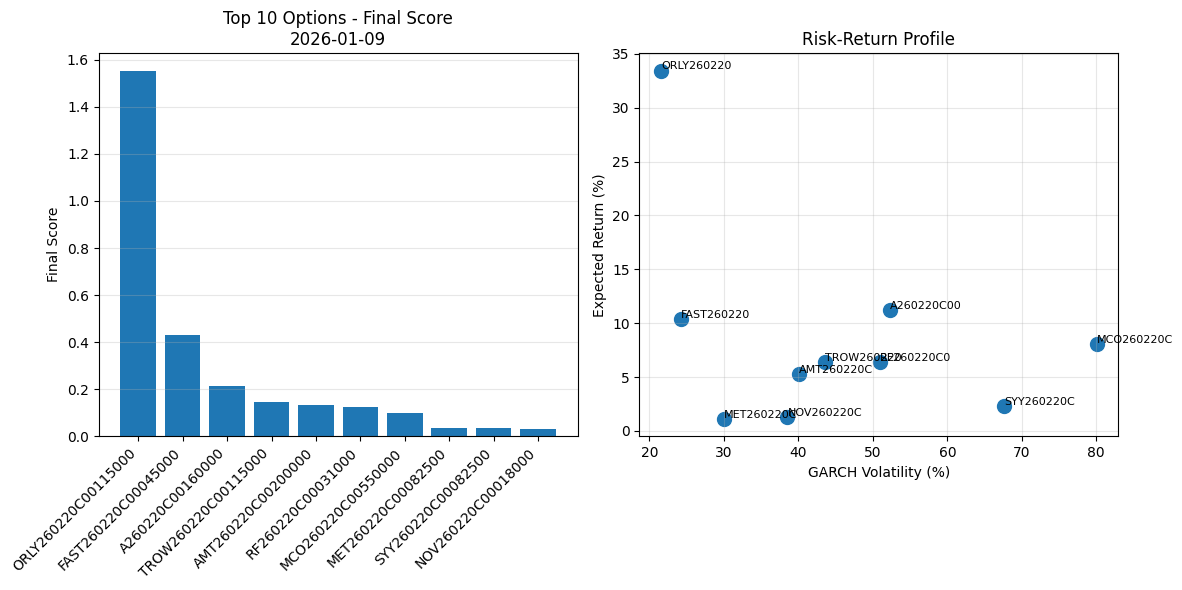

In [ ]:
# Combine all models
if reg_results is not None and not reg_results.empty:
    combined = reg_results.copy()

    # Merge ARIMA results
    if not arima_df.empty:
        combined = combined.merge(arima_df, on="symbol", how="left")
    else:
        combined["arima_expected_return"] = np.nan

    # Merge GARCH results
    if not garch_df.empty:
        combined = combined.merge(garch_df, on="symbol", how="left")
    else:
        combined["garch_sigma_1"] = np.nan

    # Calculate combined return
    combined["combined_return"] = np.where(
        combined["arima_expected_return"].notna(),
        (combined["predicted_next_return"] + combined["arima_expected_return"]) / 2.0,
        combined["predicted_next_return"]
    )

    # Handle missing volatility (use historical vol as fallback)
    combined["garch_sigma_1"] = combined["garch_sigma_1"].fillna(
        combined["vol_20"].abs() * 100.0
    )

    # Final score: return per unit of volatility (Sharpe-like ratio)
    combined["final_score"] = combined["combined_return"] / (combined["garch_sigma_1"] / 100.0 + 1e-6)

    # Sort by final score
    combined_sorted = combined.sort_values("final_score", ascending=False)

    print("\n" + "="*50)
    print("FINAL RANKING - TOP 20 OPTIONS")
    print("="*50)

    top_20 = combined_sorted.head(20)
    for i, (idx, row) in enumerate(top_20.iterrows(), 1):
        print(f"{i:2d}. {row['symbol']:25s} "
              f"Price: ${row['option_price']:7.2f} "
              f"Score: {row['final_score']:.4f} "
              f"PredReturn: {row['predicted_next_return']:.4f} "
              f"ARIMA: {row.get('arima_expected_return', np.nan):.4f} "
              f"Vol: {row['garch_sigma_1']:.2f}%")

    # Save results
    combined_sorted.to_csv("ranking_opciones_sp500_combined.csv", index=False)
    print("\nSaved results to: ranking_opciones_sp500_combined.csv")

    # Visualization
    top10 = combined_sorted.head(10)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(top10["symbol"], top10["final_score"])
    plt.title(f"Top 10 Options - Final Score\n{ASOF_EFFECTIVE}")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Final Score")
    plt.grid(True, axis='y', alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(top10["garch_sigma_1"], top10["combined_return"] * 100, s=100)
    for i, row in top10.iterrows():
        plt.text(row["garch_sigma_1"], row["combined_return"] * 100 + 0.1,
                row["symbol"][:10], fontsize=8)
    plt.xlabel("GARCH Volatility (%)")
    plt.ylabel("Expected Return (%)")
    plt.title("Risk-Return Profile")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("No regression results available for combination")

In [ ]:
# Summary statistics
print("\n" + "="*50)
print("MODEL SUMMARY STATISTICS")
print("="*50)

if not train_opt_df.empty:
    print(f"Total option observations: {len(train_opt_df)}")
    print(f"Unique options: {train_opt_df['symbol'].nunique()}")
    print(f"Date range: {train_opt_df['date'].min().date()} to {train_opt_df['date'].max().date()}")

if reg_results is not None:
    print(f"\nLinear Regression R²: {r2_score(y_test, y_pred):.4f}")

if not arima_df.empty:
    print(f"\nARIMA models successful: {len(arima_df)}")
    print(f"ARIMA avg expected return: {arima_df['arima_expected_return'].mean():.4f}")

if not garch_df.empty:
    print(f"\nGARCH models successful: {len(garch_df)}")
    print(f"GARCH avg volatility: {garch_df['garch_sigma_1'].mean():.2f}%")

print("\n" + "="*50)
print("DATA FILES CREATED:")
print("="*50)
print("1. SP500.csv - S&P 500 constituents")
print("2. sp500_options_asof_today.csv - Selected call options")
print("3. ranking_opciones_sp500_combined.csv - Final rankings")
print("\nAnalysis complete!")


MODEL SUMMARY STATISTICS
Total option observations: 1597
Unique options: 67
Date range: 2025-07-23 to 2026-01-09

Linear Regression R²: -0.0792

GARCH models successful: 59
GARCH avg volatility: 29.03%

DATA FILES CREATED:
1. SP500.csv - S&P 500 constituents
2. sp500_options_asof_today.csv - Selected call options
3. ranking_opciones_sp500_combined.csv - Final rankings

Analysis complete!
